In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv('/kaggle/input/usa-real-estate-dataset/realtor-data.zip.csv')
data=pd.DataFrame(data)
data.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [3]:
data.shape

(2226382, 12)

In [4]:
data=data.dropna(subset=['price'])

In [5]:
data.shape

(2224841, 12)

In [6]:
missing_groups = data.groupby('city')['bed'].apply(lambda x: x.isna().all())
print(missing_groups[missing_groups])

city
139th Ave Unit Peck    True
15th Ave Milton        True
177th Ave Wabasha      True
178th Ave Wabasha      True
1st Saint              True
                       ... 
Zena                   True
Zinc                   True
Zion Mountain          True
Zortman                True
Zwingle                True
Name: bed, Length: 2395, dtype: bool


In [7]:
import warnings
warnings.filterwarnings("ignore", message="Mean of empty slice")


In [8]:

import numpy as np

# List of numerical columns to handle missing values
num_features = ['bed', 'bath', 'acre_lot', 'house_size']

# Iterate over each numerical column
for col in num_features:
    # Calculate the overall median of the column (ignoring NaNs)
    overall_median = data[col].median()

    # Define a function to fill missing values within each group
    def fill_missing(x):
        # Median for the current group
        group_median = x.median()
        # Check if the group median is NaN (group is empty or all NaN)
        if np.isnan(group_median):
            return x.fillna(overall_median)  # Use overall median as fallback
        return x.fillna(group_median)  # Otherwise, use group median

    # Apply the function to fill missing values
    data[col] = data.groupby('city')[col].transform(fill_missing)



In [9]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Encode 'street' as integers
encoder = LabelEncoder()
data['street_encoded'] = encoder.fit_transform(data['street'].astype(str))

# Use city or other features to predict 'street_encoded'
imputer = SimpleImputer(strategy='most_frequent')
data['street_encoded'] = imputer.fit_transform(data[['street_encoded']])

# Decode back to original 'street' labels
data['street'] = encoder.inverse_transform(data['street_encoded'])
data.drop(columns=['street_encoded'], inplace=True)

Let's break down the code step by step, along with explanations of the concepts used:

---

### **1. Importing Modules**
```python
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
```
- **`SimpleImputer`**:
  - A class from `sklearn` used to fill (or impute) missing values in a dataset.
  - It offers strategies like replacing missing values with the mean, median, or most frequent value.

- **`LabelEncoder`**:
  - Converts categorical labels (strings) into numerical values.
  - This is useful for machine learning algorithms that can only work with numerical data.

---

### **2. Encoding `street` as Integers**
```python
encoder = LabelEncoder()
data['street_encoded'] = encoder.fit_transform(data['street'].astype(str))
```
- **What it does**:
  - Converts the `street` column (categorical) into numeric values by assigning a unique integer to each unique label (e.g., `['Main St', 'Elm St', 'Park Ave'] → [0, 1, 2]`).
  - **`astype(str)`** ensures that even `NaN` values are treated as strings, avoiding errors during encoding.

- **Key Methods**:
  - **`fit_transform`**:
    - Learns the mapping of unique labels to integers (via `fit`) and applies the transformation (via `transform`) in one step.
    - Example mapping:
      ```
      'Main St' → 0
      'Elm St' → 1
      'Park Ave' → 2
      NaN → 3
      ```

---

### **3. Handling Missing Values with `SimpleImputer`**
```python
imputer = SimpleImputer(strategy='most_frequent')
data['street_encoded'] = imputer.fit_transform(data[['street_encoded']])
```
- **What it does**:
  - Fills the missing values (`NaN`) in the `street_encoded` column using the most frequent value (mode).
  - If a column has missing values, this method replaces them with the most common value in that column.

- **Key Methods**:
  - **`fit`**:
    - Learns the most frequent value in the column.
  - **`transform`**:
    - Replaces missing values with the learned value.
  - **Example**:
    ```
    Original:
    street_encoded: [0, 1, NaN, 1, 2, NaN]
    Most Frequent Value (mode): 1
    After Imputation:
    street_encoded: [0, 1, 1, 1, 2, 1]
    ```

---

### **4. Decoding Back to Original Labels**
```python
data['street'] = encoder.inverse_transform(data['street_encoded'])
```
- **What it does**:
  - Converts the numeric `street_encoded` values back to their original string labels.
  - Uses the mapping learned during the `fit_transform` step of the `LabelEncoder`.

- **Key Method**:
  - **`inverse_transform`**:
    - Maps integers back to their original labels (e.g., `[0, 1, 2] → ['Main St', 'Elm St', 'Park Ave']`).

---

### **5. Cleaning Up**
```python
data.drop(columns=['street_encoded'], inplace=True)
```
- **What it does**:
  - Removes the temporary `street_encoded` column, as it's no longer needed.
  - **`inplace=True`** ensures the changes are applied directly to the `data` dataframe without creating a new copy.

---

### **Why This Process?**
This process is necessary because machine learning models require numerical data, and missing values cannot be directly handled by most algorithms. Here's how each step contributes:
1. **Encoding categorical data**:
   - Converts strings to integers so they can be processed.
2. **Imputing missing values**:
   - Replaces missing values with logical alternatives (e.g., mode) to avoid issues during model training.
3. **Decoding back**:
   - Converts numbers back to their original labels for human readability or downstream tasks.

---

### **Example Walkthrough**
**Input Data (`data['street']`)**:
```
['Main St', 'Elm St', NaN, 'Elm St', 'Park Ave', NaN]
```

1. **Encoded (`street_encoded`)**:
```
[0, 1, 3 (for NaN), 1, 2, 3]
```

2. **Imputed (`street_encoded`)**:
```
[0, 1, 1, 1, 2, 1]  (NaNs replaced with mode = 1)
```

3. **Decoded (`street`)**:
```
['Main St', 'Elm St', 'Elm St', 'Elm St', 'Park Ave', 'Elm St']
```

---

### **Advantages of This Approach**:
- Handles both **missing values** and **categorical data** in a structured manner.
- Allows categorical data to be imputed without complex logic.
- Decodes back to original labels for interpretability.

Let me know if you'd like further clarification!

In [10]:
data.isnull().sum()

brokered_by         4533
status                 0
price                  0
bed                 1404
bath                1404
acre_lot            1404
street                 0
city                1404
state                  8
zip_code             298
house_size          1404
prev_sold_date    733256
dtype: int64

In [11]:
data.drop(columns=['prev_sold_date'],inplace=True)

In [12]:
data.drop_duplicates(inplace=True)

In [13]:
data.shape

(2224003, 11)

In [14]:
import os
from sklearn.preprocessing import LabelEncoder
import joblib

# Ensure the "encoders" directory exists
os.makedirs("encoders", exist_ok=True)

# Initialize dictionary to store encoders
encoders = {}

# List of categorical features
categorical_features = ['city', 'state', 'status', 'brokered_by']

# Ensure all categorical values are strings and handle missing values
for feature in categorical_features:
    le = LabelEncoder()

    # Convert all values to strings and replace NaN with "Unknown"
    data[feature] = data[feature].astype(str).fillna("Unknown")

    # Fit and transform
    data[feature] = le.fit_transform(data[feature])

    # Save encoder and class mappings
    joblib.dump({'encoder': le, 'classes': le.classes_}, f'encoders/{feature}_encoder.pkl')
    print(f'{feature} encoder saved to encoders/{feature}_encoder.pkl')

print("Encoders saved successfully!")

city encoder saved to encoders/city_encoder.pkl
state encoder saved to encoders/state_encoder.pkl
status encoder saved to encoders/status_encoder.pkl
brokered_by encoder saved to encoders/brokered_by_encoder.pkl
Encoders saved successfully!


In [15]:
# Calculate the IQR for each feature
num_features=['bed', 'bath', 'house_size', 'acre_lot', 'zip_code', 'price']

for column in num_features:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Remove outliers
    data= data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [16]:
data.shape

(1553009, 11)

In [17]:
# Identify numerical features (exclude label-encoded columns if necessary)
numerical_features = ['bed', 'bath', 'house_size', 'acre_lot', 'zip_code', 'price']  # Update based on your data

# Check skewness only on numerical columns
skewness = data[numerical_features].skew()
print(skewness)

bed           0.382421
bath          0.348884
house_size    0.512836
acre_lot      1.939072
zip_code      0.133816
price         0.703359
dtype: float64


In [18]:
import numpy as np

# Apply log transformation (be sure to add 1 to avoid log(0) issues)
data['bed_log'] = np.log1p(data['bed'])  # log(x + 1)
data['bath_log'] = np.log1p(data['bath'])
data['house_size_log'] = np.log1p(data['house_size'])
data['acre_lot_log'] = np.log1p(data['acre_lot'])
data['price_log'] = np.log1p(data['price'])

# Check skewness again
print(data[['bed_log', 'bath_log', 'house_size_log', 'acre_lot_log', 'price_log']].skew())

bed_log          -0.104308
bath_log         -0.313873
house_size_log   -0.396963
acre_lot_log      1.496216
price_log        -1.756590
dtype: float64


In [19]:
# Apply square root transformation to acre_lot
data['acre_lot_sqrt'] = np.sqrt(data['acre_lot'])

# Check the skewness after square root transformation
print(data[['acre_lot_sqrt']].skew())

acre_lot_sqrt    1.073928
dtype: float64


In [20]:
# Apply cube root transformation to acre_lot
data['acre_lot_cbrt'] = np.cbrt(data['acre_lot'])

# Check the skewness after cube root transformation
print(data[['acre_lot_cbrt']].skew())

acre_lot_cbrt    0.669182
dtype: float64


In [21]:
# Apply square root transformation to price_lot
data['price_sqrt'] = np.sqrt(data['price'])

# Check the skewness after square root transformation
print(data[['price_sqrt']].skew())

price_sqrt   -0.13763
dtype: float64


In [22]:
data.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,bed_log,bath_log,house_size_log,acre_lot_log,price_log,acre_lot_sqrt,acre_lot_cbrt,price_sqrt
0,3757,0,105000.0,3.0,2.0,0.12,1962661.0,92,41,601.0,920.0,1.386294,1.098612,6.825460,0.113329,11.561725,0.346410,0.493242,324.037035
1,57581,0,80000.0,4.0,2.0,0.08,1902874.0,92,41,601.0,1527.0,1.609438,1.098612,7.331715,0.076961,11.289794,0.282843,0.430887,282.842712
2,3758,0,67000.0,2.0,1.0,0.15,1404990.0,8784,41,795.0,748.0,1.098612,0.693147,6.618739,0.139762,11.112463,0.387298,0.531329,258.843582
3,33736,0,145000.0,4.0,2.0,0.10,1947675.0,14306,41,731.0,1800.0,1.609438,1.098612,7.496097,0.095310,11.884496,0.316228,0.464159,380.788655
5,3757,0,179000.0,4.0,3.0,0.46,1850806.0,15862,41,612.0,2520.0,1.609438,1.386294,7.832411,0.378436,12.095147,0.678233,0.771944,423.083916


In [23]:
data.drop(columns=['price_log','acre_lot_sqrt','price','acre_lot_log','acre_lot','bed','bath','house_size'],axis=1,inplace=True)

In [24]:
data.head()

,brokered_by,status,street,city,state,zip_code,bed_log,bath_log,house_size_log,acre_lot_cbrt,price_sqrt
0,3757,0,1962661.0,92,41,601.0,1.386294,1.098612,6.825460,0.493242,324.037035
1,57581,0,1902874.0,92,41,601.0,1.609438,1.098612,7.331715,0.430887,282.842712
2,3758,0,1404990.0,8784,41,795.0,1.098612,0.693147,6.618739,0.531329,258.843582
3,33736,0,1947675.0,14306,41,731.0,1.609438,1.098612,7.496097,0.464159,380.788655
5,3757,0,1850806.0,15862,41,612.0,1.609438,1.386294,7.832411,0.771944,423.083916


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1553009 entries, 0 to 2226380
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   brokered_by     1553009 non-null  int64  
 1   status          1553009 non-null  int64  
 2   street          1553009 non-null  object 
 3   city            1553009 non-null  int64  
 4   state           1553009 non-null  int64  
 5   zip_code        1553009 non-null  float64
 6   bed_log         1553009 non-null  float64
 7   bath_log        1553009 non-null  float64
 8   house_size_log  1553009 non-null  float64
 9   acre_lot_cbrt   1553009 non-null  float64
 10  price_sqrt      1553009 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 142.2+ MB


In [26]:
from sklearn.preprocessing import StandardScaler
columns_to_scale = ['zip_code', 'bed_log', 'bath_log', 'house_size_log', 'acre_lot_cbrt', 'price_sqrt']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply StandardScaler to the selected columns
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Display the scaled DataFrame
data.head()

,brokered_by,status,street,city,state,zip_code,bed_log,bath_log,house_size_log,acre_lot_cbrt,price_sqrt
0,3757,0,1962661.0,92,41,-1.814897,-0.063772,-0.230391,-1.796215,-0.755004,-0.996061
1,57581,0,1902874.0,92,41,-1.814897,1.197506,-0.230391,-0.248733,-1.093096,-1.197405
2,3758,0,1404990.0,8784,41,-1.808005,-1.689842,-2.008499,-2.428105,-0.548496,-1.314706
3,33736,0,1947675.0,14306,41,-1.810279,1.197506,-0.230391,0.253739,-0.912695,-0.718677
5,3757,0,1850806.0,15862,41,-1.814506,1.197506,1.031196,1.281758,0.756124,-0.511951


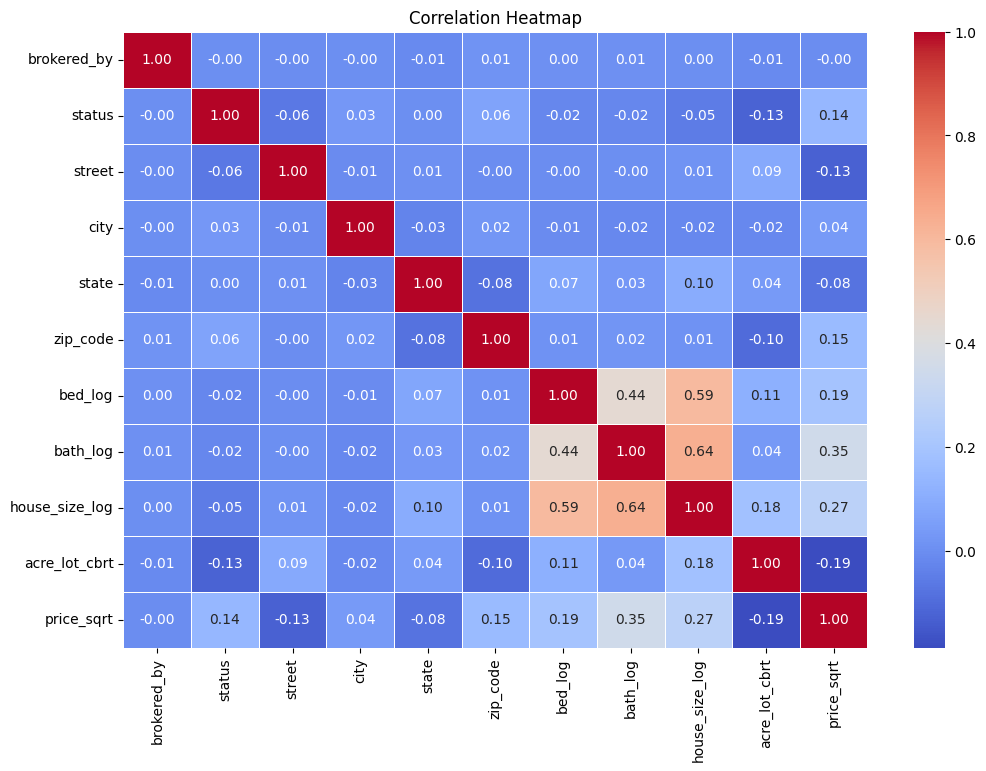

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [28]:
data['street'] = pd.to_numeric(data['street'], errors='coerce')

In [29]:
data.isnull().sum()

brokered_by          0
status               0
street            6101
city                 0
state                0
zip_code             0
bed_log              0
bath_log             0
house_size_log       0
acre_lot_cbrt        0
price_sqrt           0
dtype: int64

In [30]:
# Drop rows where 'street' column has NaN values
data = data.dropna(subset=['street'])

In [31]:
data.isnull().sum()

brokered_by       0
status            0
street            0
city              0
state             0
zip_code          0
bed_log           0
bath_log          0
house_size_log    0
acre_lot_cbrt     0
price_sqrt        0
dtype: int64

In [32]:
data.shape

(1546908, 11)

In [33]:
data['bed_bath_balance']=data['bed_log']*data['bath_log']
data['price_per_sqft']=data['price_sqrt']/data['house_size_log']
data['price_per_bedroom']=data['price_sqrt']/data['bed_log']
data['average_size_room'] = data['house_size_log'] / (data['bed_log'].replace(0, np.nan))
data['bed_bath_ratio'] = data['bed_log'] / (data['bath_log'].replace(0, np.nan))
data['efficient_land_use'] = data['house_size_log'] / (data['acre_lot_cbrt'].replace(0, np.nan))

In [34]:
print(data.isnull().sum())  # Count NaN values
print(np.isinf(data).sum())  # Count infinite values

brokered_by           0
status                0
street                0
city                  0
state                 0
zip_code              0
bed_log               0
bath_log              0
house_size_log        0
acre_lot_cbrt         0
price_sqrt            0
bed_bath_balance      0
price_per_sqft        0
price_per_bedroom     0
average_size_room     0
bed_bath_ratio        0
efficient_land_use    0
dtype: int64
brokered_by           0
status                0
street                0
city                  0
state                 0
zip_code              0
bed_log               0
bath_log              0
house_size_log        0
acre_lot_cbrt         0
price_sqrt            0
bed_bath_balance      0
price_per_sqft        0
price_per_bedroom     0
average_size_room     0
bed_bath_ratio        0
efficient_land_use    0
dtype: int64


In [35]:
# Calculate the IQR for each feature
num_features=['bed_bath_balance', 'average_size_room', 'bed_bath_ratio',
            'efficient_land_use', 'price_per_sqft', 'price_per_bedroom']

for column in num_features:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Remove outliers
    data= data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [36]:
data.shape

(528338, 17)

In [37]:
print(data[['bed_bath_balance', 'average_size_room', 'bed_bath_ratio',
            'efficient_land_use', 'price_per_sqft', 'price_per_bedroom']].skew())

bed_bath_balance      1.635632
average_size_room     0.084546
bed_bath_ratio       -0.789056
efficient_land_use   -0.052433
price_per_sqft       -0.206091
price_per_bedroom     0.097644
dtype: float64


In [38]:
data['bed_bath_balance_log'] = np.log1p(data['bed_bath_balance'])
print(data['bed_bath_balance_log'].skew())

0.6946987753691801


In [39]:
print(data[['bed_bath_balance_log', 'average_size_room', 'bed_bath_ratio',
            'efficient_land_use', 'price_per_sqft', 'price_per_bedroom']].skew())

bed_bath_balance_log    0.694699
average_size_room       0.084546
bed_bath_ratio         -0.789056
efficient_land_use     -0.052433
price_per_sqft         -0.206091
price_per_bedroom       0.097644
dtype: float64


In [40]:
data.drop(columns=['bed_bath_balance'],axis=1,inplace=True)

In [41]:
from sklearn.preprocessing import StandardScaler
columns_to_scale = ['bed_bath_balance_log','average_size_room','bed_bath_ratio',
            'efficient_land_use','price_per_sqft','price_per_bedroom']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply StandardScaler to the selected columns
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Display the scaled DataFrame
data.head()

,brokered_by,status,street,city,state,zip_code,bed_log,bath_log,house_size_log,acre_lot_cbrt,price_sqrt,price_per_sqft,price_per_bedroom,average_size_room,bed_bath_ratio,efficient_land_use,bed_bath_balance_log
17,13338,0,1868721.0,14306,41,-1.810386,-0.063772,-0.230391,-0.303228,-1.093096,-0.996061,1.167726,0.901713,0.537935,0.68345,0.136510,0.283918
35,39092,0,1902855.0,11563,41,-1.812233,-0.063772,-0.230391,0.463613,2.218097,0.119460,0.126512,-0.285468,-0.850110,0.68345,0.065714,0.283918
49,57581,0,1902736.0,115,41,-1.814862,-0.063772,-0.230391,-0.557926,-0.682689,-0.140902,0.124749,-0.008381,0.998958,0.68345,0.695353,0.283918
55,98288,0,1868699.0,115,41,-1.814862,-0.063772,-0.230391,-0.984808,-1.093096,-0.063763,0.060154,-0.090476,1.771649,0.68345,0.781985,0.283918
59,50154,0,1234597.0,115,41,-1.814862,-0.063772,-0.230391,0.796586,1.766462,-1.665449,-0.681234,1.614102,-1.452817,0.68345,0.316164,0.283918


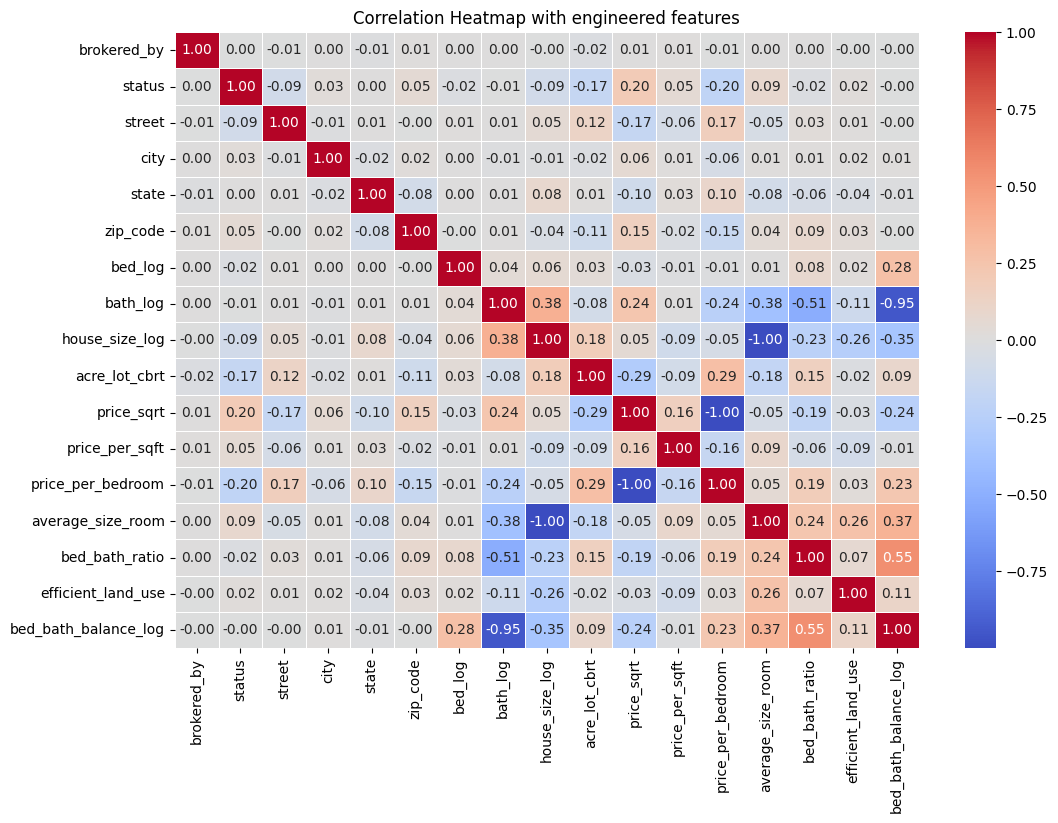

In [42]:
corr_matrix=data.corr()

#plotting heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,annot=True,cmap="coolwarm",fmt='.2f',linewidth=0.5)
plt.title('Correlation Heatmap with engineered features')
plt.show()

In [43]:
# data=data.drop(columns=['status','brokered_by'],axis=1)
data.head()

,brokered_by,status,street,city,state,zip_code,bed_log,bath_log,house_size_log,acre_lot_cbrt,price_sqrt,price_per_sqft,price_per_bedroom,average_size_room,bed_bath_ratio,efficient_land_use,bed_bath_balance_log
17,13338,0,1868721.0,14306,41,-1.810386,-0.063772,-0.230391,-0.303228,-1.093096,-0.996061,1.167726,0.901713,0.537935,0.68345,0.136510,0.283918
35,39092,0,1902855.0,11563,41,-1.812233,-0.063772,-0.230391,0.463613,2.218097,0.119460,0.126512,-0.285468,-0.850110,0.68345,0.065714,0.283918
49,57581,0,1902736.0,115,41,-1.814862,-0.063772,-0.230391,-0.557926,-0.682689,-0.140902,0.124749,-0.008381,0.998958,0.68345,0.695353,0.283918
55,98288,0,1868699.0,115,41,-1.814862,-0.063772,-0.230391,-0.984808,-1.093096,-0.063763,0.060154,-0.090476,1.771649,0.68345,0.781985,0.283918
59,50154,0,1234597.0,115,41,-1.814862,-0.063772,-0.230391,0.796586,1.766462,-1.665449,-0.681234,1.614102,-1.452817,0.68345,0.316164,0.283918


In [44]:
X=data.drop(columns=['price_sqrt'])
y=data['price_sqrt']

In [45]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=50, n_jobs=-1,max_depth=20,random_state=42)
rf_model.fit(X, y)

# Get feature importances
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print("Feature Importances:")
print(feature_importances.sort_values(ascending=False))

# Set a threshold and drop features below it
importance_threshold = 0.01  # Adjust as needed
selected_features = feature_importances[feature_importances > importance_threshold].index
X_selected = X[selected_features]

Feature Importances:
price_per_bedroom       9.981132e-01
bed_bath_ratio          8.345911e-04
bed_log                 5.988488e-04
bed_bath_balance_log    4.518675e-04
house_size_log          8.203319e-07
zip_code                2.634506e-07
street                  1.266261e-07
price_per_sqft          6.655966e-08
brokered_by             6.465316e-08
efficient_land_use      5.097279e-08
city                    4.364230e-08
acre_lot_cbrt           4.061433e-08
state                   3.033261e-08
average_size_room       2.230072e-08
status                  1.992425e-09
bath_log                8.389895e-10
dtype: float64


In [46]:
vif_data=data

In [47]:
# Assuming `rf_model` is your trained Random Forest model
import pandas as pd

# Get feature importances from the trained model
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)

# Define a threshold for feature importance
importance_threshold = 0.0001

# Retain only important features
important_features = feature_importance[feature_importance > importance_threshold].index
X_reduced = X[important_features]

# Display important features
print("Important Features Based on Threshold:")
print(important_features)

# Recalculate VIF for remaining features
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["Feature"] = X_reduced.columns
vif["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

print("\nVIF After Dropping Low-Importance Features:")
print(vif)

Important Features Based on Threshold:
Index(['bed_log', 'price_per_bedroom', 'bed_bath_ratio',
       'bed_bath_balance_log'],
      dtype='object')

VIF After Dropping Low-Importance Features:
                Feature       VIF
0               bed_log  1.008086
1     price_per_bedroom  1.063375
2        bed_bath_ratio  1.437814
3  bed_bath_balance_log  1.478152


# VIF (Variance Inflation Factor) measures the multicollinearity of features in a dataset.
# It calculates how much the variance of a regression coefficient is inflated due to multicollinearity.
# A high VIF value (generally > 5 or 10) indicates a high correlation between a feature and others, 
# meaning the feature might not provide unique information to the model.

# Steps to calculate VIF:
# 1. For each feature, regress it against all other features.
# 2. Calculate the R² (coefficient of determination) for this regression.
# 3. Compute VIF using the formula: VIF = 1 / (1 - R²)
#    - If R² is close to 1, VIF will be very large, indicating multicollinearity.
#    - Lower VIF values indicate less multicollinearity.

# VIF Thresholds:
# - VIF < 5: Low multicollinearity, the feature is generally fine.
# - VIF 5-10: Moderate multicollinearity, consider dropping or transforming the feature.
# - VIF > 10: High multicollinearity, the feature is likely problematic and should be addressed.

# In this dataset, we calculate VIF for all features to identify multicollinearity issues.
# Features with low VIF values are retained, while features with high VIF may be dropped or transformed.

In [48]:
# Final feature set
X_boosting = X[['city','state','bed_log', 'price_per_bedroom', 'bed_bath_ratio', 'bed_bath_balance_log']]

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_boosting, y, test_size=0.2, random_state=42)

In [50]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# Train
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)

# Evaluate
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 7.890685419193122e-05
R2 Score: 0.9999112774854102


In [51]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best R2 Score:", grid_search.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best R2 Score: 0.9999217374347952


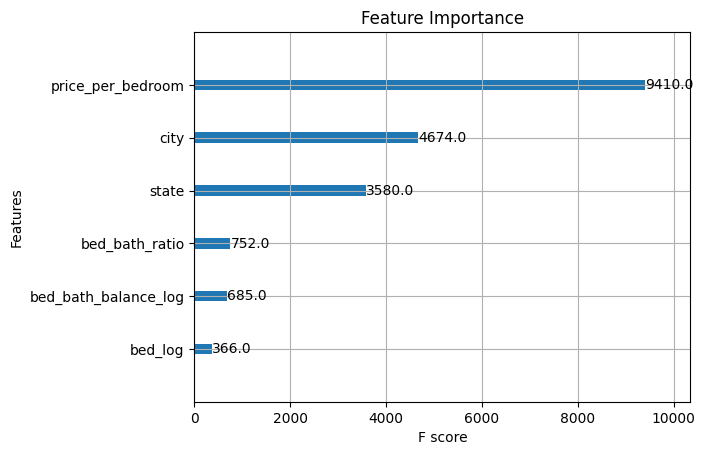

In [52]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Use the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Plot feature importance
plot_importance(best_model, max_num_features=10)  # Top 10 features
plt.title("Feature Importance")
plt.show()

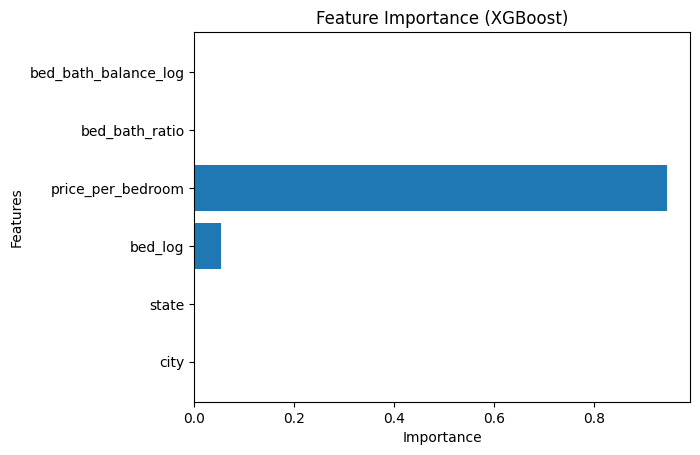

Feature Importance Ranking:
price_per_bedroom: 0.9462407231330872
bed_log: 0.05335328355431557
bed_bath_ratio: 0.00037340589915402234
city: 1.1597544471442234e-05
bed_bath_balance_log: 1.1180732144566718e-05
state: 9.841613973549102e-06


In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Feature importance
xgb_importance = best_model.feature_importances_

# Plot importance
plt.barh(X_boosting.columns, xgb_importance)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# Display sorted feature importance
sorted_importance = sorted(zip(X_boosting.columns, xgb_importance), key=lambda x: x[1], reverse=True)
print("Feature Importance Ranking:")
for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")

In [54]:
from sklearn.model_selection import cross_val_score

# Cross-validation
cv_scores = cross_val_score(best_model, X_boosting, y, cv=5, scoring='r2')

print("Cross-Validation R² Scores:", cv_scores)
print("Mean R² Score:", np.mean(cv_scores))

Cross-Validation R² Scores: [0.99990127 0.9998752  0.99990744 0.99992791 0.99986116]
Mean R² Score: 0.9998945951819053


In [55]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the best hyperparameters based on previous tuning
best_params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 300,
    'subsample': 1.0
}

# Retrain the model using the best hyperparameters
final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

# Save the model using Booster's save_model method
final_model.get_booster().save_model('xgb_final_model.json')
print("Model saved to xgb_final_model.json")

# Predict on the test set using the trained model
y_pred = final_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Mean Squared Error: {mse}")
print(f"Test R2 Score: {r2}")

# Load the model using Booster's load_model method
loaded_model = XGBRegressor()
loaded_model.load_model('xgb_final_model.json')

# Predict again to verify consistency
y_pred_loaded = loaded_model.predict(X_test)

# Check if predictions are identical
print(f"Predictions from loaded model are equal to previous predictions: {all(y_pred == y_pred_loaded)}")

Model saved to xgb_final_model.json
Test Mean Squared Error: 7.364418397692187e-05
Test R2 Score: 0.9999171948083058
Predictions from loaded model are equal to previous predictions: True


In [56]:
data.head()

,brokered_by,status,street,city,state,zip_code,bed_log,bath_log,house_size_log,acre_lot_cbrt,price_sqrt,price_per_sqft,price_per_bedroom,average_size_room,bed_bath_ratio,efficient_land_use,bed_bath_balance_log
17,13338,0,1868721.0,14306,41,-1.810386,-0.063772,-0.230391,-0.303228,-1.093096,-0.996061,1.167726,0.901713,0.537935,0.68345,0.136510,0.283918
35,39092,0,1902855.0,11563,41,-1.812233,-0.063772,-0.230391,0.463613,2.218097,0.119460,0.126512,-0.285468,-0.850110,0.68345,0.065714,0.283918
49,57581,0,1902736.0,115,41,-1.814862,-0.063772,-0.230391,-0.557926,-0.682689,-0.140902,0.124749,-0.008381,0.998958,0.68345,0.695353,0.283918
55,98288,0,1868699.0,115,41,-1.814862,-0.063772,-0.230391,-0.984808,-1.093096,-0.063763,0.060154,-0.090476,1.771649,0.68345,0.781985,0.283918
59,50154,0,1234597.0,115,41,-1.814862,-0.063772,-0.230391,0.796586,1.766462,-1.665449,-0.681234,1.614102,-1.452817,0.68345,0.316164,0.283918


In [57]:
data['city'].skew()

-0.027902399889904998

In [58]:
import joblib

# Load encoders
city_encoder = joblib.load("/kaggle/working/encoders/city_encoder.pkl")
state_encoder = joblib.load("/kaggle/working/encoders/state_encoder.pkl")

# Check their types
print("Type of city encoder:", type(city_encoder))
print("Type of state encoder:", type(state_encoder))

Type of city encoder: <class 'dict'>
Type of state encoder: <class 'dict'>


In [59]:
import joblib
from sklearn.preprocessing import LabelEncoder

# Load the incorrect encoders (which are dictionaries)
city_dict = joblib.load("/kaggle/working/encoders/city_encoder.pkl")
state_dict = joblib.load("/kaggle/working/encoders/state_encoder.pkl")

# Convert dictionary to LabelEncoder
city_encoder = LabelEncoder()
state_encoder = LabelEncoder()

# Fit the encoders with the original mapping
city_encoder.classes_ = list(city_dict.keys())  # Restore labels
state_encoder.classes_ = list(state_dict.keys())

# Save the fixed encoders
joblib.dump(city_encoder, "/kaggle/working/encoders/city_encoder_fixed.pkl")
joblib.dump(state_encoder, "/kaggle/working/encoders/state_encoder_fixed.pkl")

print("Fixed encoders saved successfully!")

Fixed encoders saved successfully!


### **Why We Had to Fix the Encoders?**  

#### **Problem: Encoders Were Saved as Dictionaries Instead of LabelEncoders**
- When loading `city_encoder.pkl` and `state_encoder.pkl`, they were found to be of type `<class 'dict'>` instead of `LabelEncoder`.  
- This caused the error:  
  ```python
  AttributeError: 'dict' object has no attribute 'transform'
  ```
  because dictionaries **don’t have a `.transform()` method**.

---

#### **Why Did This Happen?**
- When saving the encoders, they were likely stored as **dictionaries mapping labels to encoded values** instead of saving the **LabelEncoder object** itself.
- For example, the saved file may have looked like this:
  ```python
  {"New York": 0, "Los Angeles": 1, "Chicago": 2}
  ```
  instead of being a `LabelEncoder` instance with `.transform()` and `.inverse_transform()` methods.

---

#### **Solution: Convert Dictionary to LabelEncoder**
Since XGBoost expects numerical inputs, we needed to **convert these dictionaries back into LabelEncoder objects** before using them in the Flask app.

**How We Fixed It:**
1. Loaded the dictionary-based encoders.
2. Created new `LabelEncoder` objects.
3. Restored the original class labels using `classes_ = list(dictionary.keys())`.
4. Saved the corrected encoders for use in Flask.

---

### **Key Takeaways**
- **Always save the entire LabelEncoder object** using `joblib.dump(encoder, "file.pkl")`, not just the dictionary mapping.
- **Check the type of the loaded object** before using it (`type(encoders["city"])`).
- **Use `encoder.transform()` instead of manually looking up values in a dictionary.**
  
Now, the fixed encoders can be used in the Flask app without issues. 🚀

In [60]:
import xgboost as xgb
import numpy as np
import joblib
import os

# ✅ Correct Paths
MODEL_PATH = "/kaggle/working/xgb_final_model.json"
ENCODER_CITY_PATH = "/kaggle/working/encoders/city_encoder_fixed.pkl"
ENCODER_STATE_PATH = "/kaggle/working/encoders/state_encoder_fixed.pkl"

# 🔹 Load Model
if os.path.exists(MODEL_PATH):
    booster = xgb.Booster()
    booster.load_model(MODEL_PATH)
    print("✅ Model loaded successfully!")
else:
    raise FileNotFoundError(f"❌ Model file not found at {MODEL_PATH}")

# 🔹 Load Encoders
if os.path.exists(ENCODER_CITY_PATH) and os.path.exists(ENCODER_STATE_PATH):
    city_encoder = joblib.load(ENCODER_CITY_PATH)
    state_encoder = joblib.load(ENCODER_STATE_PATH)
    
    # ✅ Print type to ensure encoders are correctly loaded
    print(f"City Encoder Type: {type(city_encoder)}")  
    print(f"State Encoder Type: {type(state_encoder)}")
    
    if not hasattr(city_encoder, "transform") or not hasattr(state_encoder, "transform"):
        raise ValueError("❌ Encoders are not valid LabelEncoder objects!")

    encoders = {"city": city_encoder, "state": state_encoder}
    print("✅ Encoders loaded successfully!")
else:
    raise FileNotFoundError("❌ Encoder files not found!")

# 🔹 Function to Transform Input Data with Debugging
def transform_input(data, encoders):
    """
    Converts user input into a properly formatted NumPy array.
    """
    try:
        print(f"🔹 Raw Input Data: {data}")  # Debugging step

        # Encode city and state
        city = encoders["city"].transform([data["city"]])[0]  # Get the first element of the encoded array
        state = encoders["state"].transform([data["state"]])[0]  # Get the first element of the encoded array

        print(f"🔹 Encoded City: {city}, Encoded State: {state}")

        # Calculate derived features
        bed_log = np.log1p(float(data["bedrooms"]))
        price_per_bedroom = float(data["price"]) / float(data["bedrooms"])
        bed_bath_ratio = float(data["bedrooms"]) / float(data["bathrooms"])
        bed_bath_balance_log = np.log1p(float(data["bedrooms"]) - float(data["bathrooms"]))

        print(f"🔹 Features Before Conversion: {city, state, bed_log, price_per_bedroom, bed_bath_ratio, bed_bath_balance_log}")

        # Convert to NumPy array and reshape
        features = np.array([city, state, bed_log, price_per_bedroom, bed_bath_ratio, bed_bath_balance_log], dtype=np.float32).reshape(1, -1)

        print(f"🔹 Final Input Features (NumPy Array Shape: {features.shape}):\n", features)  # Should be (1, 6)
        return features

    except Exception as e:
        raise ValueError(f"❌ Error in transform_input: {str(e)}")

# 🔹 Example Input Data
sample_input_data = {
    "city": "New York",
    "state": "NY",
    "bedrooms": 3,
    "bathrooms": 2,
    "price": 6000
}

# 🔹 Transform Input for Model
try:
    input_features = transform_input(sample_input_data, encoders)  # ✅ Returns a NumPy array
    print(f"🔹 Final Input Features for Model: {input_features}")

    # ✅ Explicitly Convert Again to Ensure It's a NumPy Array
    input_features = np.array(input_features, dtype=np.float32).reshape(1, -1)
    print(f"🔹 Confirming Input Type Before DMatrix: {type(input_features)}, Shape: {input_features.shape}")

    dmatrix = xgb.DMatrix(input_features)  # ✅ Correct Input Type for XGBoost

    # 🔹 Make Prediction
    prediction = booster.predict(dmatrix)

    print(f"✅ Predicted Value: {round(float(prediction[0]), 2)}")  # Fixed the parenthesis here

except Exception as e:
    print(f"❌ Error in prediction: {str(e)}")

✅ Model loaded successfully!
City Encoder Type: <class 'sklearn.preprocessing._label.LabelEncoder'>
State Encoder Type: <class 'sklearn.preprocessing._label.LabelEncoder'>
✅ Encoders loaded successfully!
🔹 Raw Input Data: {'city': 'New York', 'state': 'NY', 'bedrooms': 3, 'bathrooms': 2, 'price': 6000}
❌ Error in prediction: ❌ Error in transform_input: 'list' object has no attribute 'dtype'
